## Name: Key
### ISMT S-136 Time Series Analysis with Python   
### Part II of Assignment 8

## Problem 1 (7 points)
In this problem we will consider an AR($m$)-ARCH($p$) process and learn how to identify orders $m$ and $p$. Please perform in steps:  

(a) First, set seed as np.random.seed(5432) and use ar_garch_simulate() function (please see below) to generate $n=300$ observations $x_1,x_2,\ldots,x_n$ of the following AR(3)-ARCH(2) process:

$$x_t = 1.4 \,x_{t-1} -0.8\, x_{t-2}+0.4 \,x_{t-3}+r_t,$$    
$$r_t= \sigma_t \varepsilon_t, ~\text{ where }~  \varepsilon_t \overset{\text{iid}}{\sim}\mathcal{N}(0,1),$$   
$$\sigma_t^2 = 2 +  0.3 \,r_{t-1}^2 + 0.6 \,r_{t-2}^2.$$

Plot the time series $x_t$ you generated.

(b) Plot ACF and PACF of $x_t$. Please comment on how one can identify the order $m$ if the process was just an AR($m$).  

(c) Fit AR($3$) and plot ACF/PACF of residuals. Do residuals appear to be uncorrelated? Next, plot ACF/PACF of the residuals squared. Are the residuals independent? Please explain.   

(d) Is there a way to identify the order $p$ of AR($3$)-ARCH($p$) model based on the PACF of the residuals squared you obtained in (c)?   
Hint: If $r_t$ is ARCH($p$) then $r_t^2=\alpha_0+\alpha_1 r_{t-1}^2+\ldots+\alpha_p r_{t-p}^2 + \sigma_t^2(\varepsilon_t^2-1)$.

(e) Fit AR($3$)-ARCH($2$) to the time series $x_t$. What are the estimates of the parameters $\phi_1$, $\phi_2$, $\omega$, and $\alpha$? Compare with the parameters you used to simulate the time series.

(f) Forecast $m=10$ observations using AR($3$)-ARCH($2$) model. Plot last 100 observations of the time series together with 10 forecasted values and corresponding prediction intervals.

SOLUTION:

(a)

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import acf, pacf

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.api import VAR

import warnings
warnings.filterwarnings('ignore')

Function for Generating a Sample of AR(m)-GARCH(p,q):
$$\phi(B)x_t = r_t,$$   
$$r_t= \sigma_t \varepsilon_t, ~\text{ where }~  \varepsilon_t \overset{\text{iid}}{\sim}\mathcal{N}(0,1),$$   
$$\sigma_t^2 = \underbrace{\alpha_0}_{\omega} + \sum_{j=1}^p\alpha_j r_{t-j}^2 + \sum_{j=1}^q\beta_j \sigma_{t-j}^2.$$

In [156]:
def ar_garch_simulate(phi,omega,alpha,beta,n=100):
    
    n0 = 200
    n = n0 + n
    
    m = len(phi)
    p = len(alpha)
    q = len(beta)
        
    sigma = np.zeros(n)
    rt = np.zeros(n)
    xt = np.zeros(n)
    epsilon = np.random.normal(0, 1, n)
    
    for t in range(np.max([m, p, q])):
        sigma[t] = np.random.normal(0, 1)
        rt[t] = sigma[t] * epsilon[t]
        xt[t] = rt[t]
        
    for t in range(np.max([m, p, q]), n):
        term1 = omega + sum([alpha[i] * rt[t-1-i]**2 for i in range(p)])
        term2 = sum([beta[i] * sigma[t-1-i]**2 for i in range(q)])
        sigma[t] = np.sqrt(term1 + term2)
        rt[t] = sigma[t] * epsilon[t]
        xt[t] = sum([phi[i] * xt[t-1-i] for i in range(m)]) + rt[t]
        
    return xt[n0:]

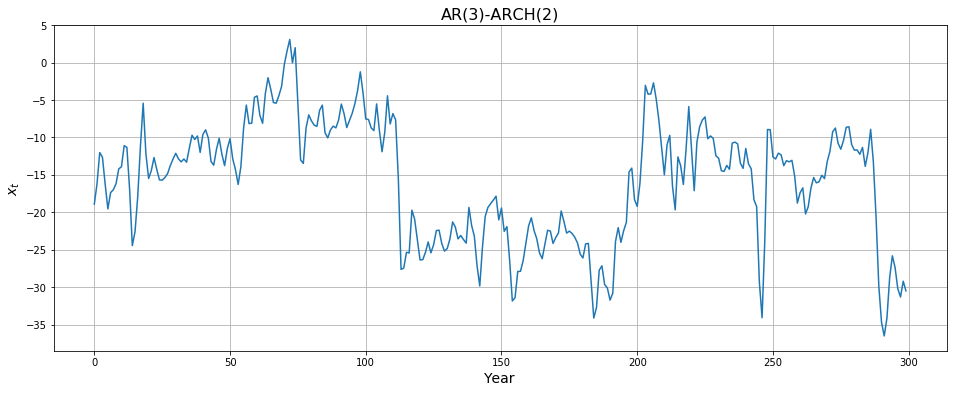

In [157]:
np.random.seed(5432)

phi = np.array([1.4, -0.8, 0.4])
omega = 2.0
alpha = np.array([0.3, 0.6])
beta = np.array([0])

p_ar = 0 if ((len(phi)==1) & (phi[0]==0)) else len(phi)
p_garch = 0 if ((len(alpha)==1) & (alpha[0]==0)) else len(alpha)
q_garch = 0 if ((len(beta)==1) & (beta[0]==0)) else len(beta)

n = 300
xt = ar_garch_simulate(phi, omega, alpha, beta, n)

plt.figure(figsize=(16,6))
plt.plot(xt)
plt.xlabel("Year", size = 14)
plt.ylabel("$x_t$", size = 14)
plt.title("AR(" + str(p_ar) + ")-ARCH(" + str(p_garch) + ")", size = 16)
plt.grid(True)
plt.show()

(b)

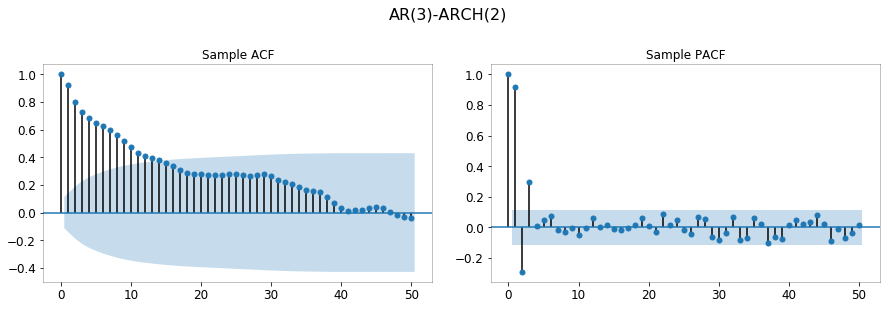

In [158]:
h_max = 50

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(15,4))
fig.suptitle("AR(" + str(p_ar) + ")-ARCH(" + str(p_garch) + ")",y=1.08,size=16)
plt.subplots_adjust(wspace = 0.15)
plot_acf(xt, ax=ax[0], lags=h_max)
plot_pacf(xt, ax=ax[1], lags=h_max, method='ywm')

for k in range(2):
    ax[k].tick_params(axis='both', labelsize=12)
    [ax[k].spines[line].set_alpha(.3) for line in ["top","bottom","right","left"]]

ax[0].set_title("Sample ACF")
ax[1].set_title("Sample PACF")

plt.show()

Based on the PACF plot, the partial autocorrelations of the process are significant/outside the bounds up until lag 3, therefore one can identify the order m if the process was an AR(m) process.

(c)

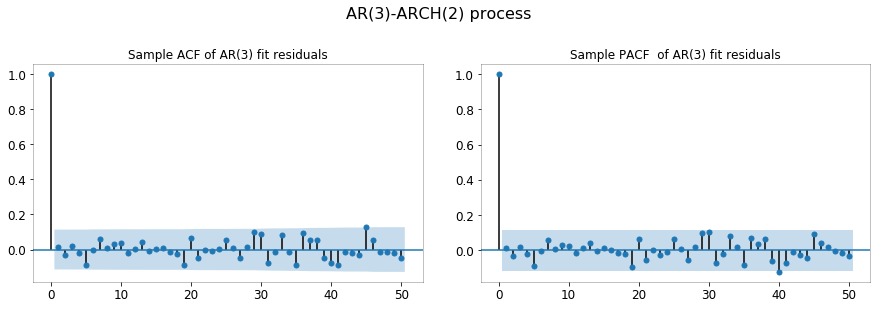

In [159]:
res = ARIMA(xt, order=(3,0,0)).fit(method='css').resid

h_max = 50

fig, ax = plt.subplots(nrows=1, ncols=2, sharex = False, figsize=(15,4))
fig.suptitle("AR(" + str(p_ar) + ")-ARCH(" + str(p_garch) + ") process",y=1.08,size=16)
plt.subplots_adjust(wspace = 0.15)
plot_acf(res, ax = ax[0], lags=h_max)
plot_pacf(res, ax = ax[1], lags=h_max, method='ywm')

for k in range(2):
    ax[k].tick_params(axis='both', labelsize=12)
    [ax[k].spines[line].set_alpha(.3) for line in ["top","bottom","right","left"]]

ax[0].set_title("Sample ACF of AR(3) fit residuals")
ax[1].set_title("Sample PACF  of AR(3) fit residuals")

plt.show()

The residuals seem to be uncorrelated as the autocorrelations are not significant over any lags.

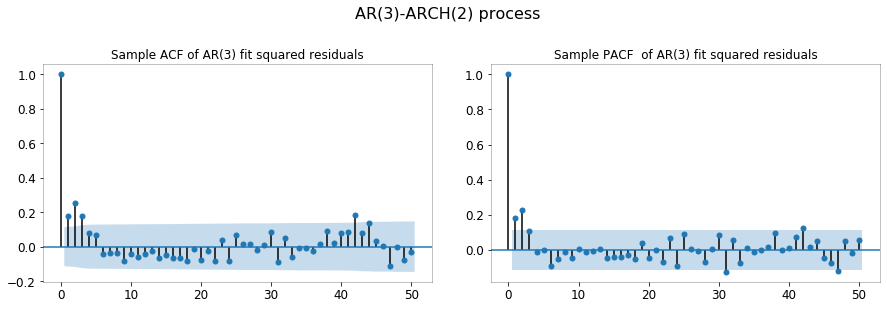

In [160]:
h_max = 50

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(15,4))
fig.suptitle("AR(" + str(p_ar) + ")-ARCH(" + str(p_garch) + ") process",y=1.08,size=16)
plt.subplots_adjust(wspace = 0.15)
plot_acf(res**2, ax=ax[0], lags=h_max)
plot_pacf(res**2, ax=ax[1], lags=h_max, method='ywm')

for k in range(2):
    ax[k].tick_params(axis='both', labelsize=12)
    [ax[k].spines[line].set_alpha(.3) for line in ["top","bottom","right","left"]]

ax[0].set_title("Sample ACF of AR(3) fit squared residuals")
ax[1].set_title("Sample PACF  of AR(3) fit squared residuals")

plt.show()

Based on the plots, one can conclude that the residuals are not independent as the autocorrelations are not fully insignifcant over all lags. For independence to hold, the autocorrelation of the squared residuals must be insignificant/inside the bounds for all lags.

(d)

The order p of $AR(3)-ARCH(p)$ can be identified using the PACF plot of suqared residuals. Thereby, the significant/outside the bounds residuals define the partial autocorrelations of squared residuals over lags and define the order of the $ARCH(p)$ model part. Hence, the order of $p = 2$ can be identified.

(e)

In [162]:
model = arch_model(xt, mean='AR',lags=3, vol='ARCH', p=2)
model_fit = model.fit()
print(model_fit.summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: 680.2800264053714
Iteration:      2,   Func. Count:     23,   Neg. LLF: 680.1706192955248
Iteration:      3,   Func. Count:     34,   Neg. LLF: 680.0187162214243
Iteration:      4,   Func. Count:     45,   Neg. LLF: 678.297683424601
Iteration:      5,   Func. Count:     56,   Neg. LLF: 677.4462925772369
Iteration:      6,   Func. Count:     66,   Neg. LLF: 675.5639413639448
Iteration:      7,   Func. Count:     76,   Neg. LLF: 675.1776488689497
Iteration:      8,   Func. Count:     86,   Neg. LLF: 674.940018091681
Iteration:      9,   Func. Count:     97,   Neg. LLF: 674.9040216364325
Iteration:     10,   Func. Count:    106,   Neg. LLF: 674.7545414920739
Iteration:     11,   Func. Count:    115,   Neg. LLF: 674.6763721065881
Iteration:     12,   Func. Count:    124,   Neg. LLF: 674.6753312981199
Iteration:     13,   Func. Count:    133,   Neg. LLF: 674.6753083065626
Optimization terminated successfully.    (Exit mode 0)
           

The parameters are as follows (compared to the simulation parameters):

$\phi_1 = 1.38$ ($1.40$)

$\phi_2 = -0.77$ ($-0.8$)

$\phi_3 = 0.37$ ($0.4$)

$\omega = \alpha_0 = 1.81$ ($2.0$)

$\alpha_1 = 0.29$ ($0.30$)

$\alpha_1 = 0.63$ ($0.60$)

In conclusion, one can observe that the parameters of the model fit are quite close to the "real" parameters from the underlying simulated process.

(f)

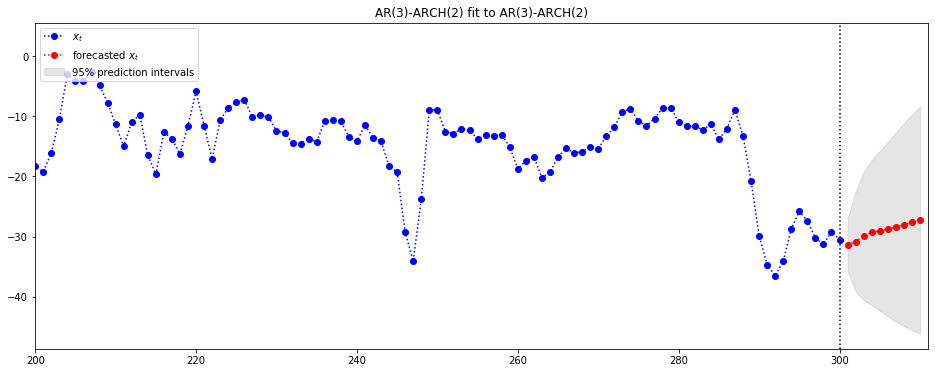

In [164]:
# check n fitted values
plt.figure(figsize=(16,6))
plt.plot(range(1,n+1),xt,linestyle=':', marker='o',color='blue',label = "$x_t$")
plt.title("AR(3)-ARCH(2) fit to AR(" + str(p_ar) + ")-ARCH(" + str(p_garch) + ")")

# forecast m steps ahead starting from n+1
m=10
model_fit_forecast = model_fit.forecast(horizon=m)
xt_forecasted = model_fit_forecast.mean.values[-1, :]
pred_intL = xt_forecasted - 1.96*np.sqrt(model_fit_forecast.variance.values[-1, :])
pred_intR = xt_forecasted + 1.96*np.sqrt(model_fit_forecast.variance.values[-1, :])
plt.axvline(x=n,linestyle=':',color='k')
plt.plot(range(n+1,n+m+1), xt_forecasted, linestyle=':', marker='o',color='red',label = "forecasted $x_t$")
plt.fill_between(range(n+1,n+m+1), pred_intL, pred_intR, color='gray', alpha=.2,label = "95% prediction intervals")
plt.legend(loc = 'upper left')
plt.xlim(n-100,n+m+1)
plt.show()

## Problem 2 (7 points)
Please load the time series saved in 'xt_hw8.txt' file. Reserve the last 10 data points for comparison, i.e. do not use them for the model analysis and model fit. Identify orders $m$ and $p$ of the AR($m$)-ARCH($p$) model for this time series.
 
Using $m$ and $p$ you identified, fit both models, AR($m$) and AR($m$)-ARCH($p$), and forecast the last $10$ observations in each case.

Plot last 100 observations of the time series including reserved observations. Add 10 forecasted values and corresponding prediction intervals according to AR($m$)-ARCH($p$) model. Add 10 forecasted values according to AR($m$) model. Please make sure to add a proper legend. Make sure to add a legend in order to differentiate between observed $x_t$ and the forecast of 10 last data points. 


Finally, compute the mean squared error (MSE) for the last 10 predictions of $x_t$ using AR($m$) and AR($m$)-ARCH($p$) models.

SOLUTION:

In [174]:
xt = np.loadtxt("xt_hw8.txt")
xt_train = xt[0:len(xt)-10]
xt_test = xt[len(xt)-10:len(xt)]

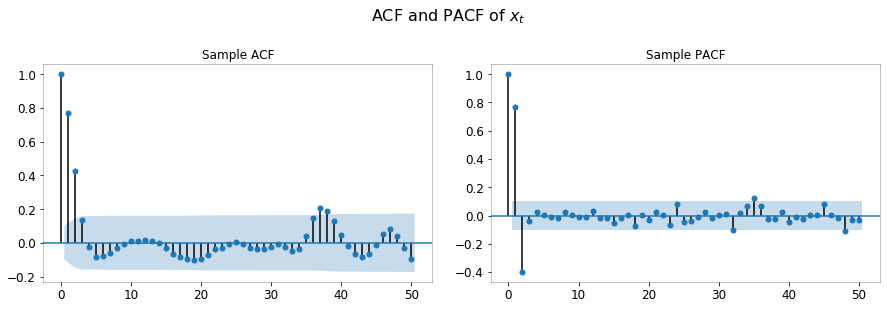

In [175]:
h_max = 50

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(15,4))
fig.suptitle("ACF and PACF of $x_t$",y=1.08,size=16)
plt.subplots_adjust(wspace = 0.15)
plot_acf(xt_train, ax=ax[0], lags=h_max)
plot_pacf(xt_train, ax=ax[1], lags=h_max, method='ywm')

for k in range(2):
    ax[k].tick_params(axis='both', labelsize=12)
    [ax[k].spines[line].set_alpha(.3) for line in ["top","bottom","right","left"]]

ax[0].set_title("Sample ACF")
ax[1].set_title("Sample PACF")

plt.show()

Based on the sample PACF and ACF, one can conclude the order $m$ of the $AR(m)$ part as $m = 2$.

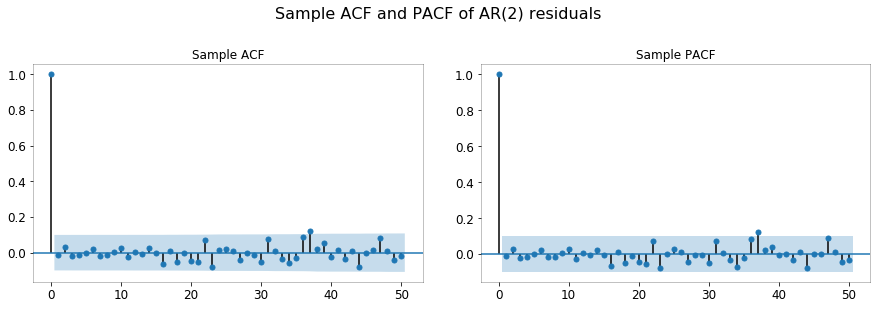

In [176]:
# Fit AR(2) model
res = ARIMA(xt_train, order=(2,0,0)).fit(method='css').resid

h_max = 50

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(15,4))
fig.suptitle("Sample ACF and PACF of AR(2) residuals",y=1.08,size=16)
plt.subplots_adjust(wspace = 0.15)
plot_acf(res, ax = ax[0], lags=h_max)
plot_pacf(res, ax = ax[1], lags=h_max, method='ywm')

for k in range(2):
    ax[k].tick_params(axis='both', labelsize=12)
    [ax[k].spines[line].set_alpha(.3) for line in ["top","bottom","right","left"]]

ax[0].set_title("Sample ACF")
ax[1].set_title("Sample PACF")

plt.show()

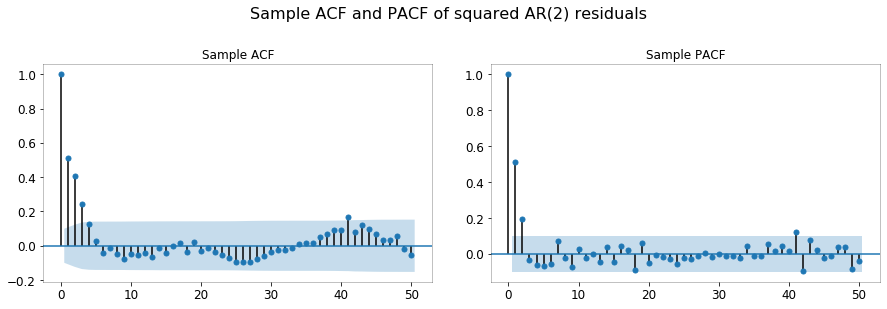

In [177]:
h_max = 50

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(15,4))
fig.suptitle("Sample ACF and PACF of squared AR(2) residuals",y=1.08,size=16)
plt.subplots_adjust(wspace = 0.15)
plot_acf(res**2, ax=ax[0], lags=h_max)
plot_pacf(res**2, ax=ax[1], lags=h_max, method='ywm')

for k in range(2):
    ax[k].tick_params(axis='both', labelsize=12)
    [ax[k].spines[line].set_alpha(.3) for line in ["top","bottom","right","left"]]

ax[0].set_title("Sample ACF")
ax[1].set_title("Sample PACF")

plt.show()

From the ACF and PACF, one can conclude the order $p$ of $AR(2)-ARCH(p)$ as $p = 2$. Hence, the model to fit is defined by $AR(2)-ARCH(2)$.

In [178]:
model_AR_ARCH = arch_model(xt_train, mean='AR',lags=2, vol='ARCH', p=2)
model_fit_AR_ARCH = model_AR_ARCH.fit()
print(model_fit_AR_ARCH.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 736.970293784872
Iteration:      2,   Func. Count:     20,   Neg. LLF: 734.8411406117136
Iteration:      3,   Func. Count:     31,   Neg. LLF: 730.6473499798086
Iteration:      4,   Func. Count:     41,   Neg. LLF: 730.4377660758464
Iteration:      5,   Func. Count:     50,   Neg. LLF: 729.0944460941106
Iteration:      6,   Func. Count:     59,   Neg. LLF: 728.6465972044707
Iteration:      7,   Func. Count:     68,   Neg. LLF: 728.2687804336476
Iteration:      8,   Func. Count:     77,   Neg. LLF: 728.0291166299032
Iteration:      9,   Func. Count:     85,   Neg. LLF: 727.8655485956019
Iteration:     10,   Func. Count:     93,   Neg. LLF: 727.689079859482
Iteration:     11,   Func. Count:    101,   Neg. LLF: 727.6741205287185
Iteration:     12,   Func. Count:    109,   Neg. LLF: 727.6735052974282
Iteration:     13,   Func. Count:    117,   Neg. LLF: 727.6734984994954
Iteration:     14,   Func. Count:    125,   Neg. LLF: 727.67349732

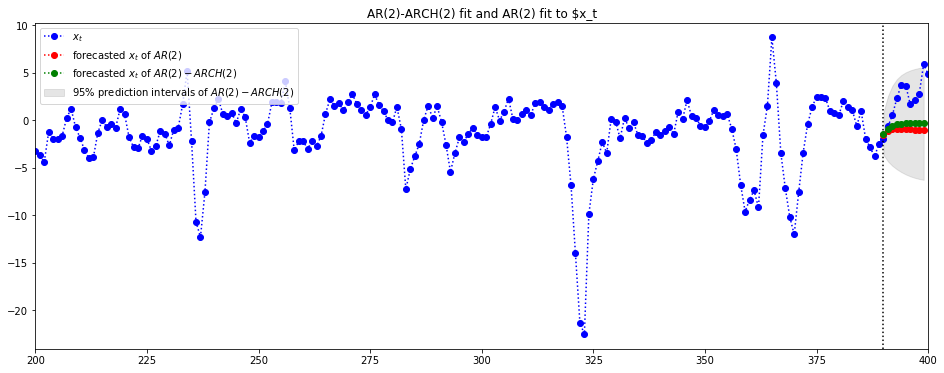


10 period forecast values of AR(2): [-1.54268801 -1.16880621 -0.96960491 -0.90491276 -0.91494057 -0.95152198
 -0.98679829 -1.01007751 -1.02099612 -1.02343029]

10 period forecast values of AR(2)-ARCH(2): [-1.4188266  -0.91886089 -0.6074581  -0.44463037 -0.37401025 -0.35144915
 -0.34964568 -0.35441602 -0.35965942 -0.36346097]

Forecasting MSE of AR(2): 16.839740808091573

Forecasting MSE of AR(2)-ARCH(2): 12.975602573379664


In [179]:
model_AR = ARIMA(xt_train, order=(2,0,0))
model_fit_AR = model_AR.fit()

# check n fitted values
plt.figure(figsize=(16,6))
plt.plot(range(1, len(xt)+1),xt,linestyle=':', marker='o',color='blue',label = "$x_t$")
plt.title("AR(2)-ARCH(2) fit and AR(2) fit to $x_t")

# forecast m steps ahead starting from n+1
m = 10
model_fit_forecast_AR_ARCH = model_fit_AR_ARCH.forecast(horizon=m)
xt_forecasted_AR = model_fit_AR.forecast(steps=m)[0]
xt_forecasted_AR_ARCH = model_fit_forecast_AR_ARCH.mean.values[-1, :]
pred_intL_AR_ARCH = xt_forecasted_AR_ARCH - 1.96*np.sqrt(model_fit_forecast_AR_ARCH.variance.values[-1, :])
pred_intR_AR_ARCH = xt_forecasted_AR_ARCH + 1.96*np.sqrt(model_fit_forecast_AR_ARCH.variance.values[-1, :])
plt.axvline(x=len(xt_train),linestyle=':',color='k')
plt.plot(range(len(xt_train),len(xt)), xt_forecasted_AR, linestyle=':', marker='o',color='red',label = "forecasted $x_t$ of $AR(2)$")
plt.plot(range(len(xt_train),len(xt)), xt_forecasted_AR_ARCH, linestyle=':', marker='o',color='green',label = "forecasted $x_t$ of $AR(2)-ARCH(2)$")
plt.fill_between(range(len(xt_train),len(xt)), pred_intL_AR_ARCH, pred_intR_AR_ARCH, color='gray', alpha=.2,label = "95% prediction intervals of $AR(2)-ARCH(2)$")
plt.legend(loc = 'upper left')
plt.xlim(200,len(xt))
plt.show()

# Forecasted values and MSEs
print("\n10 period forecast values of AR(2):", xt_forecasted_AR)
print("\n10 period forecast values of AR(2)-ARCH(2):", xt_forecasted_AR_ARCH)
print("\nForecasting MSE of AR(2):", mean_squared_error(xt_test, xt_forecasted_AR))
print("\nForecasting MSE of AR(2)-ARCH(2):", mean_squared_error(xt_test, xt_forecasted_AR_ARCH))

## Problem 3 (6 points)
In this problem we will consider a Vector Autoregressive model of order $p$, abbreviated VAR($p$), for two non-independent time series: please consider weekly data of cardiovascular mortality in Los Angeles (saved in 'cmort.csv') and also weekly measurements of particulates (saved in 'part.csv') in the city.  

Please perform in steps:  

(a) Demonstrate that the time series are not independent by presenting the cross-correlation function (CCF) plot. 
      
(b) Fit VAR(1) model and explicitly indicate what you obtained for the estimates of $\Phi_{11}, \Phi_{12}, \Phi_{21},$ and $\Phi_{22}$ in   
     
$$x_t = \Phi x_{t-1} + w_t,$$   
    
where   
   
   
$x_t = \begin{bmatrix}
x_{t,1}\\ 
x_{t,2} 
\end{bmatrix} = \begin{bmatrix}
\text{cardiovascular mortality at time }t\\ 
\text{measurements of particulates at time }t 
\end{bmatrix}$,    
   
$w_t=\begin{bmatrix}
w_{t,1}\\ 
w_{t,2} 
\end{bmatrix}$ is the vector Gaussian white noise,       
       
and     
    
$\Phi=\begin{bmatrix}
\Phi_{11} & \Phi_{12}\\ 
\Phi_{21} & \Phi_{22} 
\end{bmatrix}$ is the 2x2 matrix of coefficients.

(c) Plot the two time series with 60 step ahead forecasts.   
      
(d) Finally, fit VAR(9) model and also plot the two time series with 60 step ahead forecasts.


SOLUTION:

In [180]:
from statsmodels.tsa.api import VAR

(a)

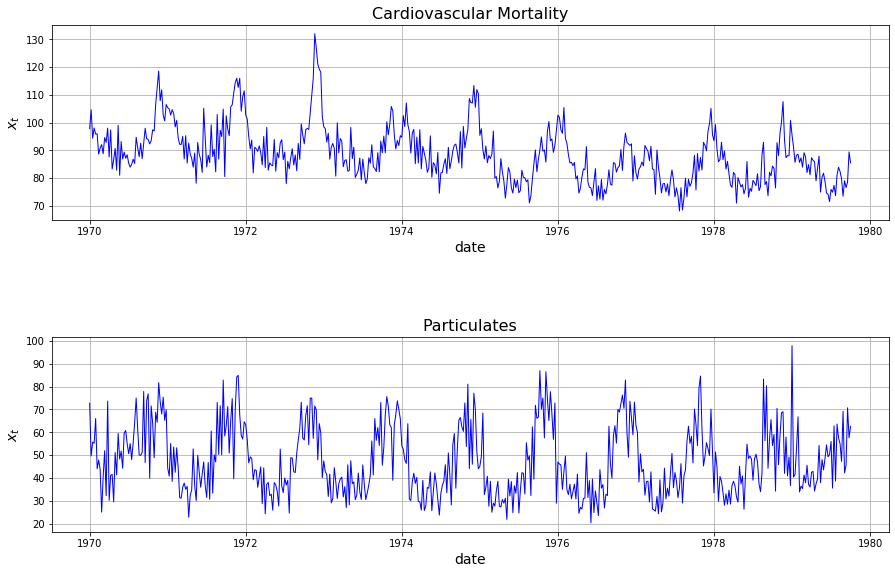

In [181]:
xt_1 = pd.read_csv("cmort.csv")
xt_2 = pd.read_csv("part.csv")
df = pd.concat([xt_1, xt_2[['part']]], axis = 1, sort = False)

titles = {"cmort": 'Cardiovascular Mortality',
          "part": 'Particulates'}

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(15,8))
plt.subplots_adjust(wspace = 0.35,hspace = 0.6,bottom = 0)

for i in range(2):
    atr = df.columns[i+1]
    ax[i].plot(df[['date']],df[atr], color='blue', linewidth=1)
    ax[i].grid(True)
    ax[i].set_xlabel("date",size = 14)
    ax[i].set_ylabel("$x_t$", size = 14)
    ax[i].set_title(titles[atr], size = 16)

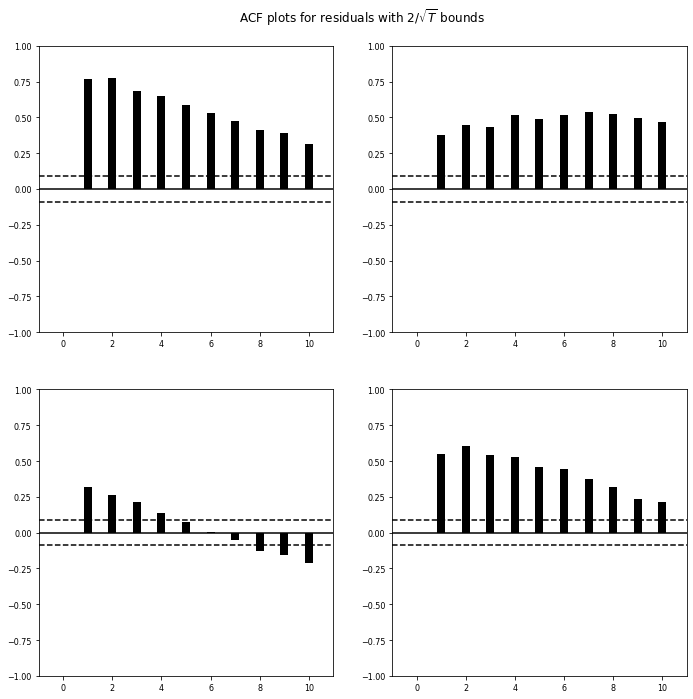

In [182]:
model = VAR(df[["cmort", "part"]])
model_fit = model.fit(0).plot_acorr()

In the diagonal plots (top left, bottom right), one can observe the ACF of the two time series themselves. The top right plot defines the cross-correlations of mortality and particulates, which shows quite significant positive correlations across the two time series. Based on that observation, from the CCFs, one can clearly observe dependence and hence no independence of the two time series.

(b)

In [183]:
model = VAR(df[["cmort", "part"]])
model_fit_1 = model.fit(1)
model_fit_1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, Jul, 2021
Time:                     21:15:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.69974
Nobs:                     507.000    HQIC:                   8.66932
Log likelihood:          -3625.50    FPE:                    5708.43
AIC:                      8.64970    Det(Omega_mle):         5641.47
--------------------------------------------------------------------
Results for equation cmort
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           20.592192         2.532116            8.132           0.000
L1.cmort         0.751656         0.031511           23.853           0.000
L1.part          0.029817         0.020832            1.431           0.152

Res

Following coefficients are produces by the $VAR(1)$ model fit:

$\Phi_{11} = 0.75$ 

$\Phi_{12} = 0.03$ 

$\Phi_{21} = 0.14$ 

$\Phi_{22} = 0.51$ 

(c)

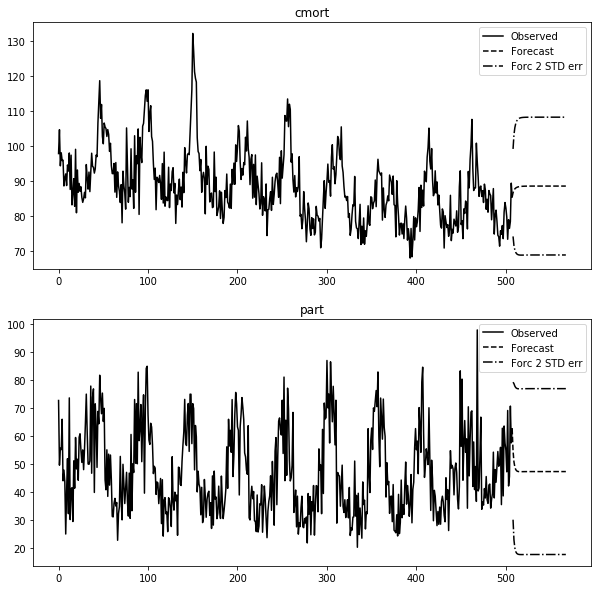

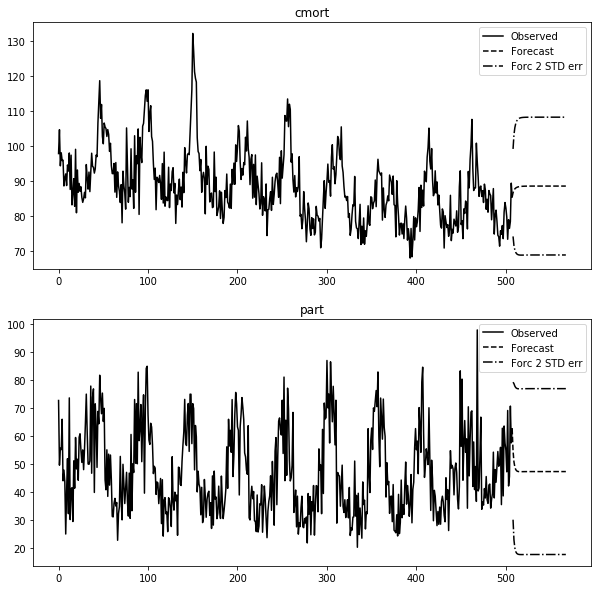

In [184]:
model_fit_1.plot_forecast(60)

(d)

In [185]:
model = VAR(df[["cmort", "part"]])
model_fit_9 = model.fit(9)
model_fit_9.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, Jul, 2021
Time:                     21:15:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.45156
Nobs:                     499.000    HQIC:                   8.25666
Log likelihood:          -3406.73    FPE:                    3397.65
AIC:                      8.13076    Det(Omega_mle):         3152.97
--------------------------------------------------------------------
Results for equation cmort
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           13.731600         3.075495            4.465           0.000
L1.cmort         0.396446         0.047311            8.380           0.000
L1.part         -0.043657         0.024267           -1.799           0.072
L2.c

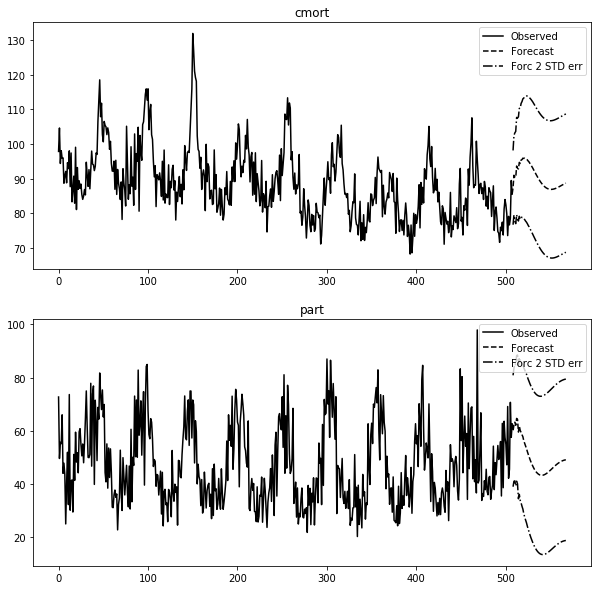

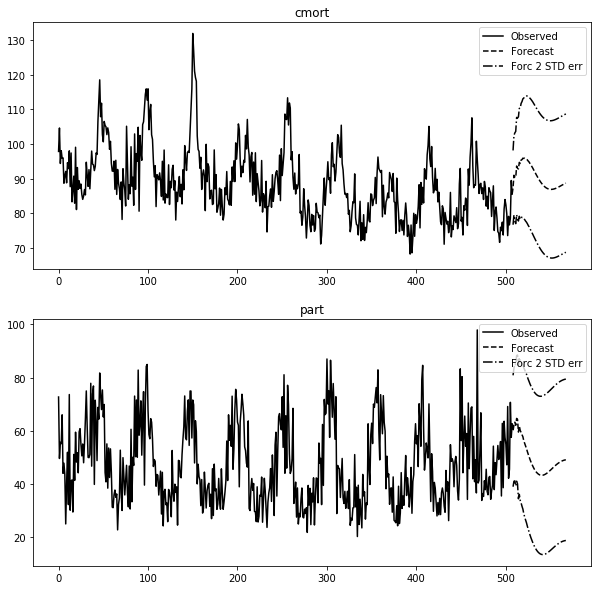

In [186]:
model_fit_9.plot_forecast(60)